In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import itertools

import warnings
warnings.filterwarnings('ignore')

In [45]:
# Load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def reformat_data(df):
    df['Month'] = pd.to_datetime(df['Month'], format='%m-%d-%Y')
    df.set_index('Month', inplace=True)
    return df

# Data preprocessing
def preprocess_data(df):
    df['Avg_sunspot_count'] = df['Avg_sunspot_count'].replace(0, 0.01)
    df['Avg_sunspot_count'] = pd.to_numeric(df['Avg_sunspot_count'], errors='coerce')
    return df

# Decomposition
def decompose_data(df, model_type, period):
    rcParams['figure.figsize'] = 10, 8
    decomp = seasonal_decompose(df, model=model_type, period=period)
    decomp.plot()
    plt.show()

# Smoothing
def apply_smoothing(df, column, trend_type, seasonal_type, seasonal_periods):
    model = ExponentialSmoothing(
        df[column],
        trend=trend_type,
        seasonal=seasonal_type,
        seasonal_periods=seasonal_periods
    )
    fit = model.fit()
    df['smoothed'] = fit.fittedvalues
    return df

# Stationarity test
def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# ARIMA model fitting
def fit_arima(train, order):
    model = ARIMA(train, order=order)
    results = model.fit()
    return results

# Forecast and evaluate
def forecast_and_evaluate(model, test):
    forecast = model.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"RMSE: {rmse}")
    return forecast, rmse

In [46]:
df = load_data('data/train.csv')
df.head()

,Month,Avg_sunspot_count
0,01-01-1749,97
1,02-01-1749,104
2,03-01-1749,117
3,04-01-1749,93
4,05-01-1749,142


In [47]:
df = reformat_data(df)
df = preprocess_data(df)
df.head()

,Avg_sunspot_count
Month,
1749-01-01,97.0
1749-02-01,104.0
1749-03-01,117.0
1749-04-01,93.0
1749-05-01,142.0


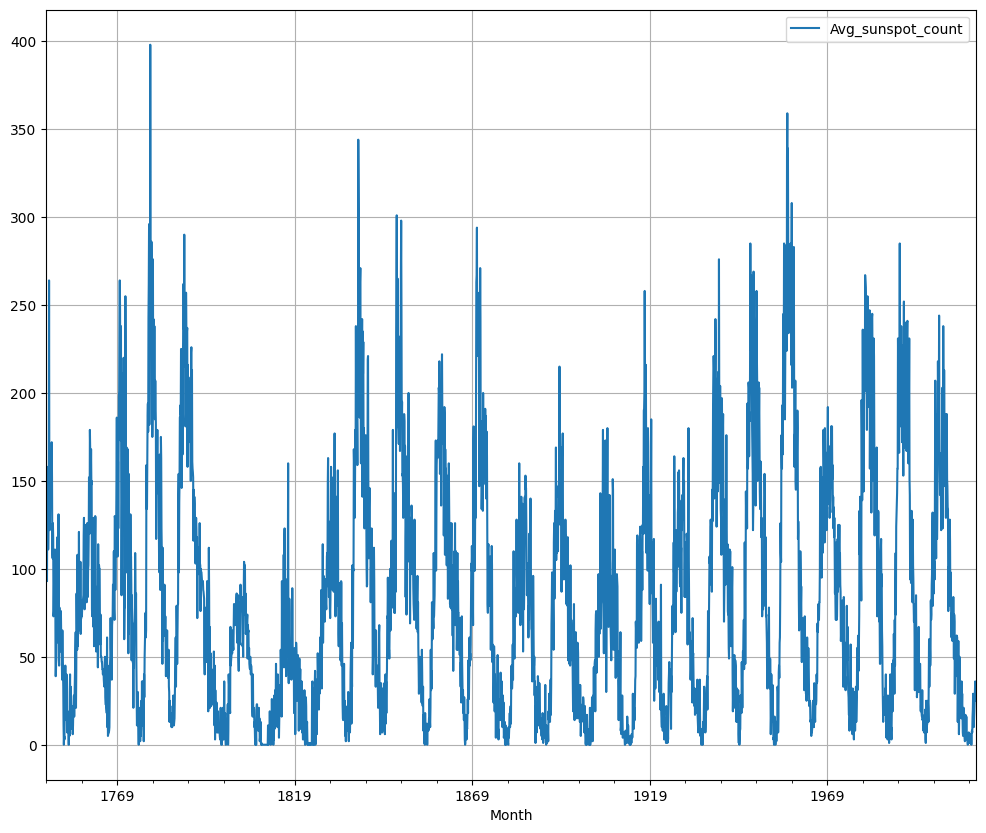

In [48]:
# Plot original data
df.plot(figsize=(12, 10), grid=True)
plt.show()

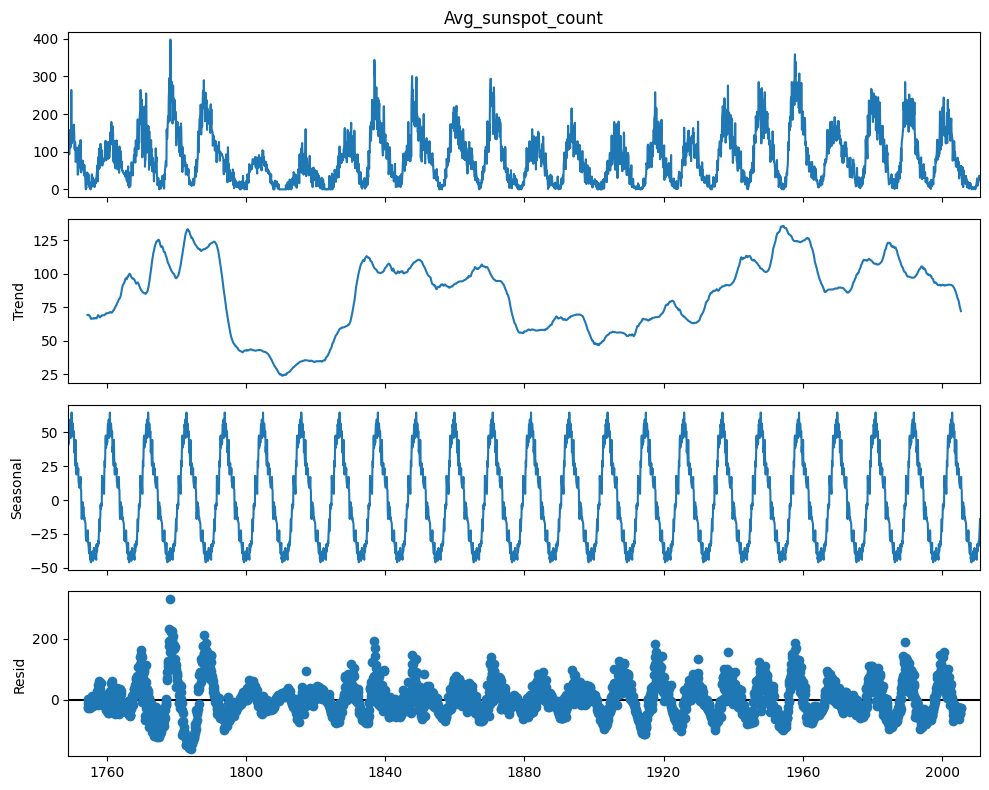

In [51]:
# Decomposition (Additive)
decompose_data(df['Avg_sunspot_count'], 'additive', 132)

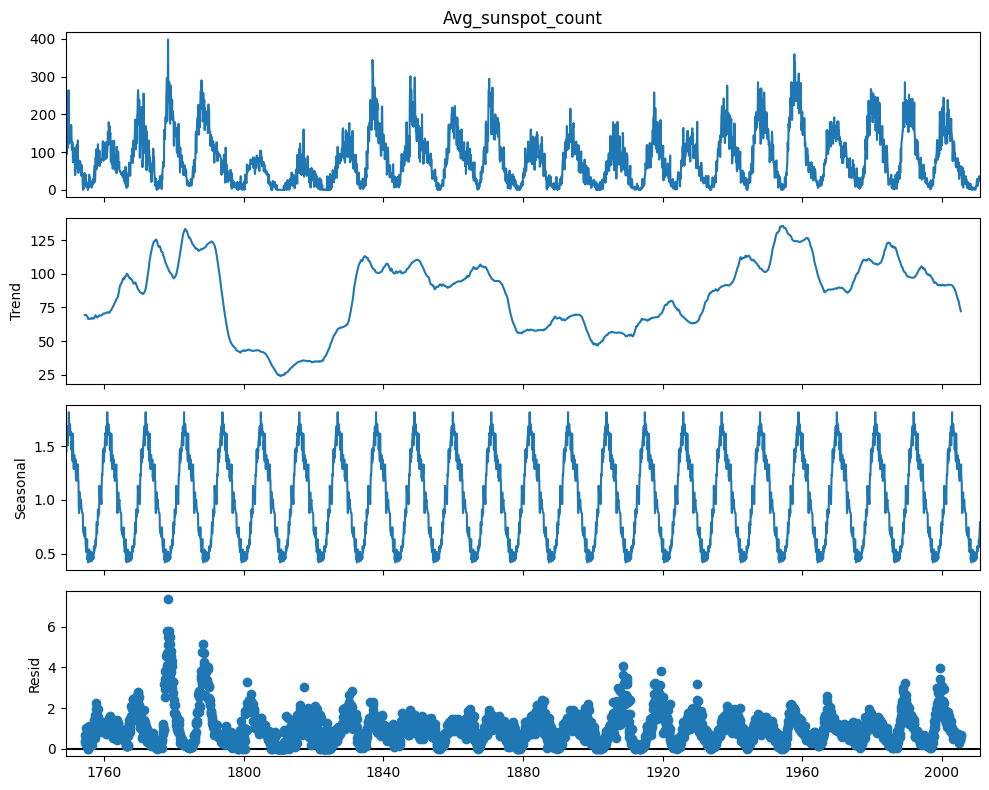

In [50]:
# Decomposition (Multiplicative)
decompose_data(df['Avg_sunspot_count'], 'multiplicative', 132)

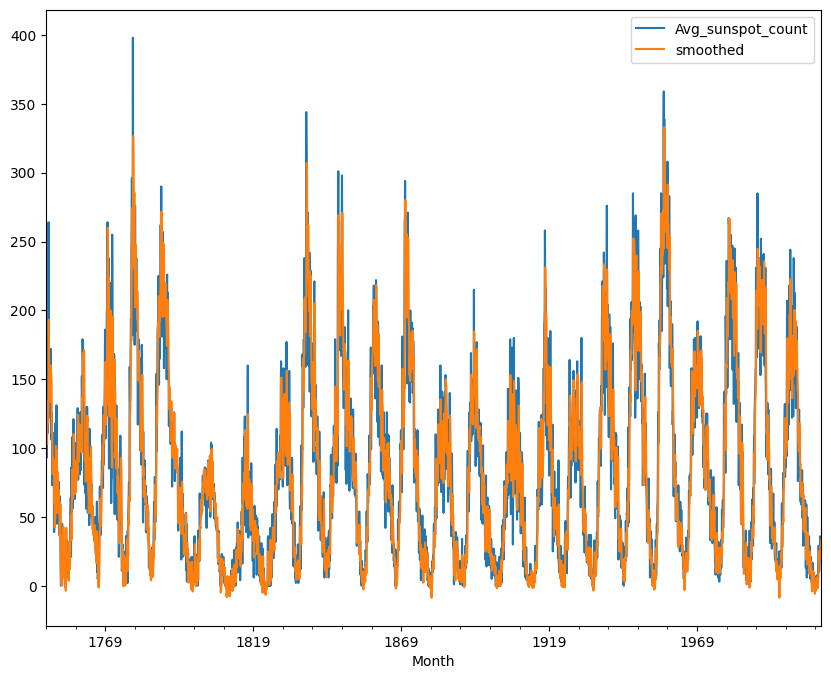

In [52]:
# Smoothing
df = apply_smoothing(df, 'Avg_sunspot_count', 'add', 'add', 12)
df.plot();

In [53]:
# Stationarity test
test_stationarity(df['smoothed'])

ADF Statistic: -10.590346
p-value: 0.000000


In [54]:
# Split data into train and test
train_end = datetime(1990, 12, 31)
test_end = datetime(2010, 12, 31)
train = df[:train_end]
test = df[train_end + timedelta(days=1):test_end]

In [55]:
# Grid search for best ARIMA parameters
p = q = range(0, 10)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])

for param in pdq:
    ARIMA_model = ARIMA(train['smoothed'], order=param).fit()
    ARIMA_AIC = pd.concat([ARIMA_AIC, pd.DataFrame([{'param': param, 'AIC': ARIMA_model.aic}])], ignore_index=True)

best_params = ARIMA_AIC.sort_values(by='AIC', ascending=True).iloc[0]['param']

In [56]:
# Fit ARIMA with best parameters
results_Arima = fit_arima(train['smoothed'], best_params)
print(results_Arima.summary())

                               SARIMAX Results                                
Dep. Variable:               smoothed   No. Observations:                 2904
Model:                 ARIMA(6, 1, 9)   Log Likelihood              -11789.723
Date:                Sun, 23 Feb 2025   AIC                          23611.446
Time:                        13:05:21   BIC                          23707.022
Sample:                    01-01-1749   HQIC                         23645.882
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6536      0.096      6.799      0.000       0.465       0.842
ar.L2          0.8663      0.040     21.927      0.000       0.789       0.944
ar.L3          0.2071      0.072      2.882      0.0

In [57]:
# Forecast and evaluate
forecast, rmse = forecast_and_evaluate(results_Arima, test['smoothed'])

RMSE: 120.95231655749556


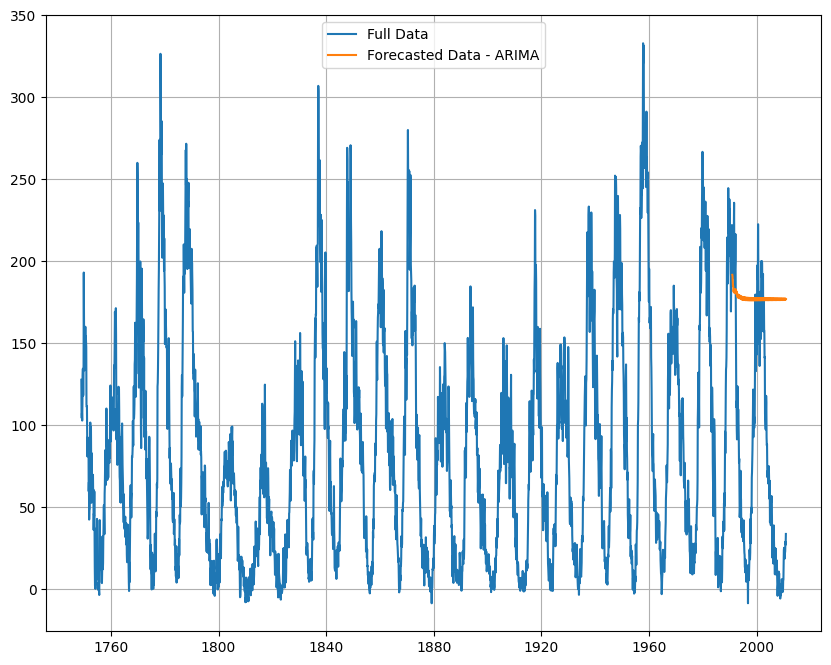

In [58]:
# Plot results
plt.plot(df['smoothed'], label='Full Data')
plt.plot(test.index, forecast, label='Forecasted Data - ARIMA')
plt.legend(loc='best')
plt.grid()
plt.show()

In [59]:
# Final forecast for submission
sample_submission = pd.read_csv('data/test.csv')
final_forecast = results_Arima.forecast(steps=len(sample_submission))
final_submission = sample_submission[['Month']].copy()
final_submission['Avg_sunspot_count'] = final_forecast.values
final_submission.to_csv('sunspot_forecast_arima.csv', index=False)